## Cal-CRAI metric: cold spell freqency

This notebook walks through how to calculate the extreme heat loss metric: `# of cold days` using Cal-Adapt: Analytics Engine data. This notebook may be expanded or modified for inclusion in cae-notebooks in the future. 

**Order of operations**:
1. Read data in
2. Calculate base function (FFWI, SPEI, warm nights, etc.)
3. Calculate chronic
4. Calculate delta signal
5. Reprojection to census tracts
6. Min-max standardization
7. Export data

**Runtime**: This notebook will take approximately 1 hour to run due to data size, warming levels, and reprojection steps. 

### Step 0: Import libraries

In [1]:
import climakitae as ck
from climakitae.explore import warming_levels 
from climakitae.util.utils import add_dummy_time_to_wl
from climakitae.core.data_interface import DataParameters

import pandas as pd
import numpy as np
import geopandas as gpd

import pyproj
import rioxarray as rio
import xarray as xr

# projection information
import cartopy.crs as ccrs
crs = ccrs.LambertConformal(
    central_longitude=-70, 
    central_latitude=38, 
    false_easting=0.0, 
    false_northing=0.0,  
    standard_parallels=[30, 60], 
    globe=None, 
    # cutoff=-30
)

In [2]:
sims_wl = [
    'WRF_MPI-ESM1-2-HR_r3i1p1f1_Historical + SSP 3-7.0 -- Business as Usual',
    'WRF_MIROC6_r1i1p1f1_Historical + SSP 3-7.0 -- Business as Usual',
    'WRF_EC-Earth3_r1i1p1f1_Historical + SSP 3-7.0 -- Business as Usual',
    'WRF_TaiESM1_r1i1p1f1_Historical + SSP 3-7.0 -- Business as Usual',
]
sims_hist = [
    'WRF_MPI-ESM1-2-HR_r3i1p1f1',
    'WRF_MIROC6_r1i1p1f1', 
    'WRF_EC-Earth3_r1i1p1f1',
    'WRF_TaiESM1_r1i1p1f1', 
]

sim_name_dict = dict(zip(sims_wl,sims_hist)) 

def count_delta_extreme_cold_events(ds_hist, ds_wl):    
  
    # define the months over which we are going to 
    # determine the 2nd percentile temperature threshold
    # to define a cold spell
    months_to_measure = [m for m in np.arange(1,13,1)]
    
    sim_coord_dict = dict(zip(sims_wl,sims_hist))
    
    ds_hist = ds_hist.squeeze()
    ds_wl = ds_wl.squeeze()
    ds_template = ds_hist.isel(time=0, simulation=0).squeeze()
    # first set consistent coordinates
    ds_hist = ds_hist.sortby("simulation")
    ds_wl = ds_wl.rename({"all_sims" : "simulation"})
    ds_wl = ds_wl.sortby("simulation")
    ds_wl = ds_wl.assign_coords({'simulation': list(sim_coord_dict.values())})
    ds_wl = ds_wl.transpose("simulation","time","y","x")

    # compute 2nd percentile historical temperature
    thresh_ds = ds_hist.sel(
        time=ds_hist.time.dt.month.isin(months_to_measure)).chunk(
            dict(time=-1)).quantile(0.02, dim="time")
    
    # count total days < 2nd percentile in historical data and take annual average
    hist_count = xr.where(ds_hist < thresh_ds, x=1, y=0).groupby(
        "time.year").sum().mean(dim="year").mean(dim="simulation")
    
    # count total days < 2nd percentile in warming levels data and take annual average
    chronic_count = xr.where(ds_wl < thresh_ds, x=1, y=0).groupby(
        "time.year").sum().mean(dim="year").mean(dim="simulation")
    
    # get the delta signal
    delta_count = chronic_count - hist_count
    
    # nan out non-CA grid points
    delta_count = xr.where(np.isnan(ds_template), x=np.nan, y=delta_count)
    return delta_count

def reproject_to_tracts(ds_delta, ca_boundaries):
    # this step takes about 12 minutes with 3km data (~1 min with 9km data)
    df = ds_delta.to_dataframe().reset_index()
    gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.x,df.y))
    gdf = gdf.set_crs(crs)
    gdf = gdf.to_crs(ca_boundaries.crs)
    
    ca_boundaries = ca_boundaries.set_index(['GEOID'])    

    clipped_gdf = gpd.sjoin_nearest(ca_boundaries, gdf, how='left')
    clipped_gdf = clipped_gdf.drop(['index_right'], axis=1)
    clipped_gdf = clipped_gdf.reset_index()[
        ["GEOID",f"{ds_delta.name}","geometry"]]
    ### some coastal tracts do not contain any land grid cells ###
    
    # aggregate the gridded data to the tract level
    clipped_gdf_diss = clipped_gdf.reset_index().dissolve(
        by='GEOID', aggfunc='mean')
    clipped_gdf_diss = clipped_gdf_diss.rename(
        columns={f"{ds_delta.name}_right":
                 ds_delta.name}
    )
    
    # separate tracts with data from tracts without data
    clipped_gdf_nan = clipped_gdf_diss[np.isnan(
        clipped_gdf_diss[ds_delta.name]
    )]
    clipped_gdf_nan = clipped_gdf_nan[["geometry",ds_delta.name]]
    clipped_gdf_valid = clipped_gdf_diss[~np.isnan(
        clipped_gdf_diss[ds_delta.name]
    )]
    clipped_gdf_valid = clipped_gdf_valid[["geometry",ds_delta.name]]

    # compute the centroid of each tract
    clipped_gdf_nan["centroid"] = clipped_gdf_nan.centroid
    clipped_gdf_nan = clipped_gdf_nan.set_geometry("centroid")
    clipped_gdf_valid["centroid"] = clipped_gdf_valid.centroid
    clipped_gdf_valid = clipped_gdf_valid.set_geometry("centroid")
    
    # fill in missing tracts with values from the closest tract
    # in terms of distance between the tract centroids
    clipped_gdf_filled = clipped_gdf_nan.sjoin_nearest(clipped_gdf_valid, how='left')
    clipped_gdf_filled = clipped_gdf_filled[["geometry_left",f"{ds_delta.name}_right"]]
    clipped_gdf_filled = clipped_gdf_filled.rename(columns={
        "geometry_left":"geometry", f"{ds_delta.name}_right":ds_delta.name
    })
    clipped_gdf_valid = clipped_gdf_valid.drop(columns="centroid")
 
    # concatenate filled-in tracts with the original tract which had data
    gdf_all_tracts = pd.concat([clipped_gdf_valid,clipped_gdf_filled])

    return gdf_all_tracts


def min_max_standardize(df, col):
    '''
    Calculates min and max values for specified columns, then calculates
    min-max standardized values.

    Parameters
    ----------
    df: DataFrame
        Input dataframe   
    cols_to_run_on: list
        List of columns to calculate min, max, and standardize
    '''
    max_value = df[col].max()
    min_value = df[col].min()

    # Get min-max values, standardize, and add columns to df
    prefix = col # Extracting the prefix from the column name
    df[f'{prefix}_min'] = min_value
    df[f'{prefix}_max'] = max_value
    df[f'{prefix}_min_max_standardized'] = ((df[col] - min_value) / (max_value - min_value))

    # note to add checker to make sure new min_max column values arent < 0 > 1
    df[f'{prefix}_min_max_standardized'].loc[df[f'{prefix}_min_max_standardized'] < 0] = 0
    df[f'{prefix}_min_max_standardized'].loc[df[f'{prefix}_min_max_standardized'] > 1] = 1
    
    return df

### Step 1: Retrieve data
We need to calculate:
* 30 year centered around 2.0C warming level (SSP3-7.0)
* Historical baseline 1981-2010 (Historical Climate)

Note: the 3km data is too large to work with for all of CA for warming level conditions. Working with 9km for now.

#### Step 1a) Chronic data (2.0°C WL)

In [3]:
## Step 1a) Chronic data (2.0degC WL)
wl = warming_levels()
wl.wl_params.timescale = "daily"
wl.wl_params.downscaling_method = "Dynamical"
wl.wl_params.variable = "Air Temperature at 2m"
wl.wl_params.area_subset = "states"
wl.wl_params.cached_area = ["CA"]
wl.wl_params.warming_levels = ["2.0"]
wl.wl_params.units = "degF"
wl.wl_params.resolution = "9 km"
wl.wl_params.anom = "No"
wl.calculate()
ds = wl.sliced_data['2.0']
ds = ds.sel(all_sims = sims_wl)
ds = add_dummy_time_to_wl(ds) # add time dimension back in, as this is removed by WL and is required for xclim functionality
ds

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Returned data array is huge. Operations could take 10x to infinity longer than 1GB of data !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



Computing each warming level:   0%|          | 0/1 [00:00<?, ?it/s]

Processing data to read 3.52 GB of data into memory... 
[########################################] | 100% Completed | 134.09 s
Complete!


<xarray.DataArray 'Air Temperature at 2m' (warming_level: 1, time: 10950,
                                           y: 144, x: 60, all_sims: 4)>
array([[[[[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
...
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]]]]], dtype=float32)
Coordinates:
  * warming_level      (warming_level) object '2.0'
  * time               (time) datetime64[ns] 2000-01-01 ... 2029-12-23
  * x                  (x) float64 -4.278e+06 -4.269e+06 ... -3.747e+06
  * y                  (y) float64 5.479e+05 5.569e+05 ... 1.826e+06 1.835e+06
    lakemask           (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    landmask           (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    lat                (y, x) float32 30.96 31.01 31.05 ... 43.34 43.39 43.44
    lon                (y, x) float32 -117.9 -117.8 -117.7 ... -121.6 -121.5
    Lambert_Conformal  int64 0
    centered_year      (all_sims) int64 2045 2053 2034 2040
  * all_sims           (all_sims) <U70 'WRF_MPI-ESM1-2-HR_r3i1p1f1_Historical...
Attributes:
    variable_id:           t2
    extended_description:  Temperature of the air 2m above Earth's surface. T...
    units:                 degF
    data_type:             Gridded
    resolution:            9 km
    frequency:             daily
    location_subset:       ['CA']
    grid_mapping:          Lambert_Conformal
    institution:           UCLA
    window:                15
    months:                [ 1  2  3  4  5  6  7  8  9 10 11 12]

#### Step 1b) Historical baseline data (1981-2010)

In [4]:
selections = DataParameters()
selections.area_average = 'No'
selections.timescale = 'daily'
selections.variable = 'Air Temperature at 2m'
selections.area_subset = 'states'
selections.cached_area = ['CA']
selections.scenario_historical = ['Historical Climate']
selections.time_slice = (1981, 2010)
selections.resolution = '9 km'
selections.units = 'degF'
ds_hist = selections.retrieve().squeeze()
ds_hist = ds_hist.sel(simulation=sims_hist)
ds_hist

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
! Returned data array is large. Operations could take up to 5x longer than 1GB of data!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



,Array,Chunk
Bytes,1.41 GiB,21.97 MiB
Shape,"(4, 10957, 144, 60)","(1, 2131, 53, 51)"
Count,94 Graph Layers,576 Chunks
Type,float32,numpy.ndarray


### Step 2: Calculate delta signal
Difference between chronic (at 2.0°C warming level) and historical baseline (1981-2010)

In [5]:
cold_delta_ds = count_delta_extreme_cold_events(
    ds_hist, ds
)
cold_delta_ds = ck.load(cold_delta_ds)
cold_delta_ds.name = "mean_change_cold_days"

Processing data to read 67.50 KB of data into memory... 

/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


Complete!


In [6]:
cold_delta_ds.min(), cold_delta_ds.max()

(<xarray.DataArray 'mean_change_cold_days' ()>
 array(-4.90833333)
 Coordinates:
     time               datetime64[ns] 1981-01-01
     simulation         <U26 'WRF_MPI-ESM1-2-HR_r3i1p1f1'
     Lambert_Conformal  int64 0
     scenario           <U18 'Historical Climate'
     quantile           float64 0.02
     warming_level      <U3 '2.0',
 <xarray.DataArray 'mean_change_cold_days' ()>
 array(-2.33333333)
 Coordinates:
     time               datetime64[ns] 1981-01-01
     simulation         <U26 'WRF_MPI-ESM1-2-HR_r3i1p1f1'
     Lambert_Conformal  int64 0
     scenario           <U18 'Historical Climate'
     quantile           float64 0.02
     warming_level      <U3 '2.0')

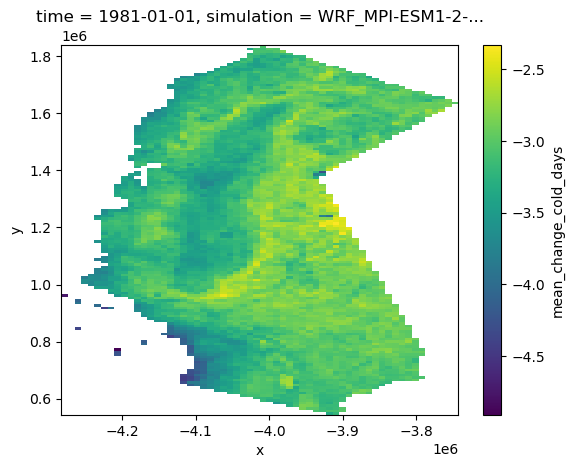

In [7]:
cold_delta_ds.plot()

### Step 3: Reproject data to census tract projection

In [8]:
# load in census tract shapefile
# census_shp_dir = "s3://ca-climate-index/0_map_data/2021_tiger_census_tract/2021_ca_tract/" # pcluster run
census_shp_dir = "2021_ca_tract/tl_2021_06_tract.shp" # local run, requires having census tracts loaded in file tree

ca_boundaries = gpd.read_file(census_shp_dir)

# convert to area-preserving CRS
ca_boundaries = ca_boundaries.to_crs(crs=3310)
cold_day_df = reproject_to_tracts(cold_delta_ds, ca_boundaries)

In [9]:
cold_day_df

,geometry,mean_change_cold_days
GEOID,,
06001401700,"POLYGON ((-206298.129 -20273.575, -205769.321 ...",-3.550000
06001401800,"POLYGON ((-202415.440 -20802.917, -202412.897 ...",-3.550000
06001402200,"POLYGON ((-202628.627 -20748.474, -202614.660 ...",-3.550000
06001402500,"POLYGON ((-201219.635 -21311.256, -201213.604 ...",-3.550000
06001402600,"POLYGON ((-200752.825 -21441.274, -200748.519 ...",-3.550000
...,...,...
06111008900,"POLYGON ((74197.106 -426806.965, 74197.216 -42...",-3.725000
06111009100,"POLYGON ((75807.393 -424740.823, 75807.025 -42...",-3.725000
06111009200,"POLYGON ((74479.459 -419077.479, 74535.192 -41...",-3.725000


### Step 4: Min-max standardization

In [10]:
# Using Cal-CRAI min-max standardization function, available in `utils.calculate_index.py`
cold_day_std = min_max_standardize(cold_day_df, col=cold_delta_ds.name)

### Step 5: Export as csv

In [11]:
# clean up dataframes prior to export
cold_day_std = cold_day_std.drop(columns=['geometry'])

# export
cold_day_std.to_csv('climate_heat_cold_days_metric.csv')

In [12]:
cold_day_std

,mean_change_cold_days,mean_change_cold_days_min,mean_change_cold_days_max,mean_change_cold_days_min_max_standardized
GEOID,,,,
06001401700,-3.550000,-4.75,-2.55,0.545455
06001401800,-3.550000,-4.75,-2.55,0.545455
06001402200,-3.550000,-4.75,-2.55,0.545455
06001402500,-3.550000,-4.75,-2.55,0.545455
06001402600,-3.550000,-4.75,-2.55,0.545455
...,...,...,...,...
06111008900,-3.725000,-4.75,-2.55,0.465909
06111009100,-3.725000,-4.75,-2.55,0.465909
06111009200,-3.725000,-4.75,-2.55,0.465909
